In [6]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
#
# Code adapted from QizGloria team, Qiskit Camp Europe 2019, updated by 
# Team Ube Pancake, Qiskit Summer Jam 2020
#
# WORKS for Quantum Circuit with variable number of qubits! Now supports running on GPU (CUDA)

In [7]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
#     print("Running on the GPU")
# else:
#     device = torch.device("cpu")
#     print("Running on the CPU")
    
# torch.device("cpu")

In [8]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [9]:
from tqdm import tqdm

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
np.random.seed = 42

NUM_QUBITS = 4
NUM_SHOTS = 1000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [12]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


Define function to translate Q-Circuit parameters from pytorch back to QISKIT

## 3. Contruct QuantumCircuit QFT Class

In [13]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
        
#         # Apply controlled-unitary
# #         uc=ry(self.theta4, 4).to_gate().control(4)
# #         self.circuit.append(uc, [0,1,2,3,4])
#         self.circuit.ry(self.theta4, 4).to_gate().control(4)

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
#             check = perc
#             for i in range(nr_qubits):
#                 check *= (float(key[i])-1/2)*2
#             expects += check   
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) /shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
#         print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
    
        job_sim = execute(self.circuit,
                              self.backend,
                              shots=self.shots,
                              parameter_binds = [{self.thetas[k] : params[k].item() for k in range(NUM_QUBITS)}])
#         
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,NUM_QUBITS)

Expected value for rotation [pi/4]: [0.    0.003 0.003 0.014 0.004 0.008 0.018 0.091 0.002 0.02  0.022 0.084
 0.012 0.088 0.096 0.535]


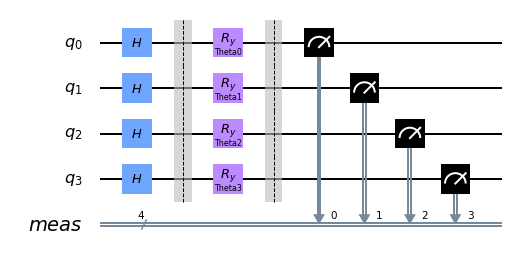

In [14]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')#, filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS)

### TorchCircuit()

A pytorch layer always has two functions. One for the forward pass and one for the backward pass. The forward pass simply takes the Quantum Circuits variational parameters from the previous pytorch layer and runs the circuit on the defined hardware (defined in `QiskitCircuit.run()`) and returns the measurements from the quantum hardware.
These measurements will be the inputs of the next pytorch layer.

The backward pass returns the gradients of the quantum circuit. In this case here it is finite difference.

the `forward_tensor` is saved from the forward pass. So we just have to do one evaluation of the Q-Circuit in the backpass for the finite difference.

The `gradient` variable here is as well hard coded to 3 parameters. This should be updated in the future and made more general.

The loop `for k in range(len(input_numbers)):` goes through all the parameters (in this case 3), and shifts them by a small $\epsilon$. Then it runs the circuit and takes the diefferences of the ouput for the parameters $\Theta$ and $\Theta + \epsilon$. This is the finite difference. 

In [15]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
        
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
#         print('forward_tensor = {}'.format(forward_tensor))
        input_numbers = i
#         print('input_numbers = {}'.format(input_numbers))
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        return (result.float() * grad_output.float()).T

In [16]:
x = torch.tensor([np.pi/4]*NUM_QUBITS, requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print('y1 after quantum layer: {}'.format(y1))
y1 = nn.Linear(2**NUM_QUBITS,1)(y1.float())
y1.backward()
print('x.grad = {}'.format(x.grad))

y1 after quantum layer: tensor([[0.0000, 0.0030, 0.0030, 0.0150, 0.0020, 0.0210, 0.0150, 0.0930, 0.0030,
         0.0160, 0.0220, 0.0810, 0.0160, 0.0930, 0.0970, 0.5200]],
       dtype=torch.float64, grad_fn=<TorchCircuitBackward>)
x.grad = tensor([ 0.0262,  0.0817, -0.0241,  0.1050])


### Test the Quantum Circuit's Gradient Descent

First, we want the "neural net" consisting of just the quantum circuit (with its 4 inputs and 4 outputs) and a linear layer (from 4 inputs to 1 output) that scales measurement 1 by 1, measurement 2 by 2, etc., until it converges to a target value (-1). So, we define a cost function where the cost is defined as the square distance from the target value.

`x` is the initialization of the parameters. Here, every angle in the quantum circuit starts at $\pi/4$. We should see that the loss eventually goes down.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.77it/s]


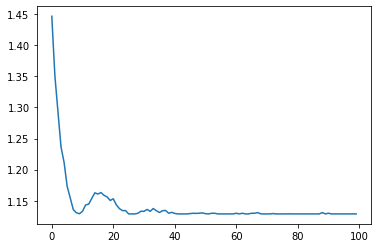

In [17]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    # simple linear layer: average all outputs of quantum layer
#     print(expval)
    val = sum([(i+1)*expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS
#     print(val)
    return torch.abs(val - target) ** 2, expval

x = torch.tensor([-np.pi/4]*NUM_QUBITS, requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)

plt.plot(loss_list)

### MNIST in pytorch

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Load MNIST (0-1) Dataset

**Training Data**

In [19]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

# Concentrating on the first 100 samples
n_samples = 150

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 6)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

**Testing Data**

In [20]:
n_samples = 200

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 6)[0][:n_samples])


X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

### Define Neural Network with Q-node

This NN is  2 layers of ConvNN and a fully connected layer, with a Q-Node as a classifier.

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 1)
        self.fc3 = nn.Linear(1, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)
        
#         print('params to QC: {}'.format(x))

        MODE = 'QC' # 'QC' or 'QC_sim'
    
        if MODE == 'QC': 
            x = qc(x[0]) # QUANTUM LAYER
        
        else:
            x = self.qcsim(x)
            
#         print('output of QC = {}'.format(x))
        
#         # softmax rather than sigmoid
#         x = self.fc3(x.float())
#         print('output of Linear(1, 2): {}'.format(x))
#         x = F.softmax(x, 1)

        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
#         print(x)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()#.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)

# optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [29]:
epochs = 5
loss_list = []
loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(batch_idx)
        optimizer.zero_grad()        
        # Forward pass
        output = network(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [20%]	Loss: 3.4275
Training [40%]	Loss: 3.3794
Training [60%]	Loss: 3.3337
Training [80%]	Loss: 3.3184
Training [100%]	Loss: 3.3103


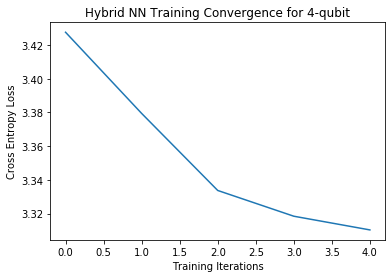

In [30]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.savefig('Figures/{}- qubit Loss Curve ryN - 0123456 - 5 epochs old archetecture.jpg'.format(NUM_QUBITS))

### Test accuracy of NN

The outcome is not always the same because the prediction is probabilistic.

In [31]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(test_loader):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

In [32]:
print("Performance on test data is is: {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is is: 628/1050 = 59.80952380952381%


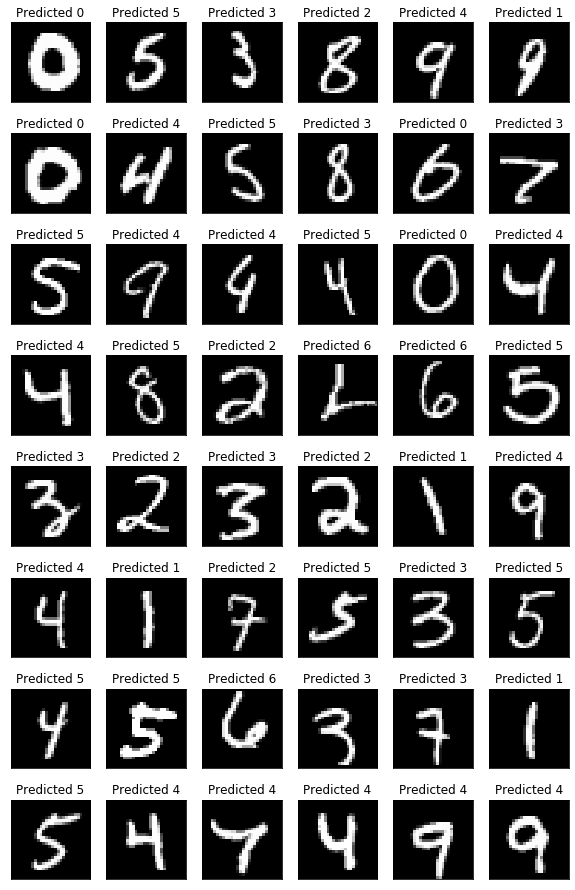

In [33]:
n_samples_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_samples_shape[0], ncols=n_samples_shape[1], figsize=(10, 2*n_samples_shape[0]))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_shape[0]*n_samples_shape[1]:
            break
        pred = network.predict(data).item()

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_xticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_yticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_title('Predicted {}'.format(pred))
        
        count += 1

In [27]:
1/6

0.16666666666666666

In [ ]:
Performance on test data is is: 244/1050 = 23.238095238095237%
            self.qcsim = nn.Linear(NUM_QUBITS, 2)
        self.fc3 = nn.Linear(2, 3)
        5 epochs